#### Sentiment polarity dataset
![image.png](attachment:image.png)

https://www.cs.cornell.edu/people/pabo/movie-review-data/


In [41]:
import pandas as pd
import numpy as np 
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
from nltk import pos_tag

from wordcloud import WordCloud
import matplotlib.pyplot as plt, seaborn as sb
import os
from glob import glob

# nltk.download('stopwords')
# nltk.download('wordnet')
import warnings
warnings.filterwarnings("ignore")

# !pip install swifter
import swifter #multi-threading/processing

### Data Understanding & Cleaning

In [7]:
pos_files = glob('../Data/txt_sentoken/pos/*')
neg_files = glob('../Data/txt_sentoken/neg/*')

def read_txt(FilePath):
    with open(FilePath,'r') as fp:
        txt = fp.read()
    return txt

POS_TXTS = [read_txt(fp) for fp in pos_files]
NEG_TXTS = [read_txt(fp) for fp in neg_files]

In [6]:
len(pos_files),len(neg_files)

(1000, 1000)

In [13]:
temp = ['some text1','some text2']
pd.DataFrame(zip(temp,['POS']*len(temp)))

0    1
0  some text1  POS
1  some text2  POS

In [12]:
# list(zip([1,2,3],[4,5,6]))

[(1, 4), (2, 5), (3, 6)]

In [15]:
Datax = pd.DataFrame(list(zip(POS_TXTS, [1]*len(POS_TXTS))) + list(zip(NEG_TXTS,[0]*len(NEG_TXTS))) ,
            columns =['text','target'])

In [16]:
Datax.head()

text  target
0  films adapted from comic books have had plenty...       1
1  every now and then a movie comes along from a ...       1
2  you've got mail works alot better than it dese...       1
3   " jaws " is a rare film that grabs your atten...       1
4  moviemaking is a lot like being the general ma...       1

<AxesSubplot:ylabel='target'>

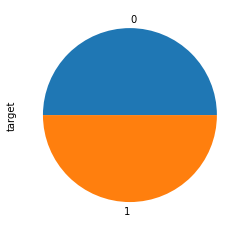

In [21]:
Datax.target.value_counts().plot(kind='pie')

In [23]:
Datax.iloc[0]['text']

'films adapted from comic books have had plenty of success , whether they\'re about superheroes ( batman , superman , spawn ) , or geared toward kids ( casper ) or the arthouse crowd ( ghost world ) , but there\'s never really been a comic book like from hell before . \nfor starters , it was created by alan moore ( and eddie campbell ) , who brought the medium to a whole new level in the mid \'80s with a 12-part series called the watchmen . \nto say moore and campbell thoroughly researched the subject of jack the ripper would be like saying michael jackson is starting to look a little odd . \nthe book ( or " graphic novel , " if you will ) is over 500 pages long and includes nearly 30 more that consist of nothing but footnotes . \nin other words , don\'t dismiss this film because of its source . \nif you can get past the whole comic book thing , you might find another stumbling block in from hell\'s directors , albert and allen hughes . \ngetting the hughes brothers to direct this seem

In [30]:
Datax.text = Datax.text.str.lower()
Datax.text = Datax.text.swifter.apply(lambda x:re.sub('[^a-zA-Z]',' ',x))
Datax.text = Datax.text.swifter.apply(lambda x:re.sub(' +',' ',x))

Pandas Apply:   0%|          | 0/2000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2000 [00:00<?, ?it/s]

In [55]:
sw = stopwords.words('english')
lem = WordNetLemmatizer()

def token_process(text):
    tokens = word_tokenize(text)
    tokens = list(filter(lambda x:x not in sw , tokens))
    processed_token = []
    for w,pos in pos_tag(tokens):
        try:
            processed_token.append(lem.lemmatize(w,pos[0].lower()))
        except:
            processed_token.append(lem.lemmatize(w))
    processed_text = ' '.join(processed_token)
    return processed_text

In [56]:
token_process('just checking if the pos works')

'check po work'

In [57]:
Datax.text = Datax.text.swifter.apply(token_process)

Pandas Apply:   0%|          | 0/2000 [00:00<?, ?it/s]

In [58]:
Datax.text

0       film adapt comic book plenty success whether s...
1       every movie come along suspect studio every in...
2       get mail work alot better deserves order make ...
3       jaw rare film grab attention show single image...
4       moviemaking lot like general manager nfl team ...
                              ...                        
1995    anything stigma take warn release similarly th...
1996    john boorman zardoz goofy cinematic debacle fu...
1997    kid hall acquire taste take least season watch...
1998    time john carpenter great horror director cour...
1999    two party guy bob head haddaway dance hit love...
Name: text, Length: 2000, dtype: object

In [59]:
Datax.shape

(2000, 2)

In [53]:
# pos_tag(word_tokenize('python is awesome'))

### EDA

In [64]:
POS_WORDS = Datax[Datax.target==1].text.str.split().values.tolist()
NEG_WORDS = Datax[Datax.target==0].text.str.split().values.tolist()

POS_WORDS = [w for seq in POS_WORDS for w in seq]
NEG_WORDS = [w for seq in NEG_WORDS for w in seq]

In [65]:
len(POS_WORDS), len(NEG_WORDS)

(371976, 330448)

In [66]:
nltk.FreqDist(POS_WORDS).most_common(10)

[('film', 6182),
 ('movie', 3163),
 ('one', 3156),
 ('make', 2175),
 ('character', 2064),
 ('like', 1933),
 ('see', 1789),
 ('get', 1734),
 ('time', 1579),
 ('go', 1479)]

In [67]:
nltk.FreqDist(NEG_WORDS).most_common(10)

[('film', 4998),
 ('movie', 3818),
 ('one', 2874),
 ('make', 2085),
 ('like', 2011),
 ('get', 1993),
 ('character', 1815),
 ('go', 1564),
 ('time', 1427),
 ('even', 1402)]

In [71]:
POS_DIST = pd.DataFrame(nltk.FreqDist(POS_WORDS).items() ,columns = ['word','WordCount_pos'])
POS_DIST = POS_DIST.set_index('word')

NEG_DIST = pd.DataFrame(nltk.FreqDist(NEG_WORDS).items() ,columns = ['word','WordCount_neg'])
NEG_DIST = NEG_DIST.set_index('word')

In [80]:
COM_DIST = POS_DIST.join(NEG_DIST)
COM_DIST = COM_DIST.fillna(1)
COM_DIST = COM_DIST[(COM_DIST.WordCount_pos +COM_DIST.WordCount_neg)>50]
COM_DIST['ratio'] = np.log(COM_DIST.WordCount_pos/COM_DIST.WordCount_neg)

In [81]:
COM_DIST.sort_values(by='ratio',ascending=False).head(20)

WordCount_pos  WordCount_neg     ratio
word                                               
mulan                   96            1.0  4.564348
flynt                   79            1.0  4.369448
shrek                   63            1.0  4.143135
lebowski                55            1.0  4.007333
bulworth                58            2.0  3.367296
damon                   69            4.0  2.847812
truman                 152           11.0  2.625985
outstanding             69            5.0  2.624669
finest                  50            5.0  2.302585
derek                   62            7.0  2.181224
jedi                    71            9.0  2.065455
religion                47            6.0  2.058388
scorsese                62            8.0  2.047693
wonderfully             75           10.0  2.014903
ripley                  56           10.0  1.722767
balance                 50            9.0  1.714798
spacey                  44            8.0  1.704748
beautifully             43            8.0  1.681759
ideal                   48            9.0  1.673976
era                     72           14.0  1.637609

In [82]:
COM_DIST.sort_values(by='ratio',ascending=True).head(20)

WordCount_pos  WordCount_neg     ratio
word                                                 
seagal                     2           74.0 -3.610918
schumacher                 3           54.0 -2.890372
godzilla                  14          120.0 -2.148434
lame                      15           96.0 -1.856298
poorly                    14           80.0 -1.742969
waste                     42          229.0 -1.696052
ridiculous                22          118.0 -1.679642
awful                     21          111.0 -1.665008
worst                     49          259.0 -1.665008
eve                       11           54.0 -1.591089
unfunny                   15           73.0 -1.582409
uninteresting             10           48.0 -1.568616
bang                      10           47.0 -1.547563
stupid                    45          209.0 -1.535672
dull                      24          111.0 -1.531476
boring                    22           99.0 -1.504077
painfully                 11           49.0 -1.493925
arnold                    18           80.0 -1.491655
pointless                 17           75.0 -1.484275
laughable                 14           60.0 -1.455287

In [83]:
wordcloud = WordCloud(background_color = 'black', width = 800, height = 400,
                      colormap = 'viridis', max_words = 180, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      random_state = 0)

In [84]:
most_freq_neg = COM_DIST.sort_values(by='ratio',ascending=True).head(50).index

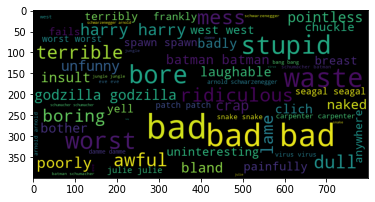

In [91]:
wordcloud.generate(' '.join([w for w in NEG_WORDS if w in most_freq_neg.tolist()]))
plt.imshow(wordcloud)


## Feature Extraction

The text needs to be transformed to vectors so as the algorithms will be able make predictions. In this case it will be used the Term Frequency – Inverse Document Frequency (TFIDF) weight to evaluate __how important a word is to a document in a collection of documents__.

After removing __punctuation__ and __lower casing__ the words, importance of a word is determined in terms of its frequency.

### “Term Frequency – Inverse Document Frequency 

__TF-IDF__ is the product of the __TF__ and __IDF__ scores of the term.<br><br> $$\text{TF-IDF}=\frac{\text{TF}}{\text{IDF}}$$<br>

__Term Frequency :__ This summarizes how often a given word appears within a document.

$$\text{TF} = \frac{\text{Number of times the term appears in the doc}}{\text{Total number of words in the doc}}$$<br><br>
__Inverse Document Frequency:__ This downscales words that appear a lot across documents. A term has a high IDF score if it appears in a few documents. Conversely, if the term is very common among documents (i.e., “the”, “a”, “is”), the term would have a low IDF score.<br>

$$\text{IDF} = \ln\left(\frac{\text{Number of docs}}{\text{Number docs the term appears in}} \right)$$<br>

TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents. The higher the TFIDF score, the rarer the term is. For instance, in a Mortgage complaint the word _mortgage_ would be mentioned fairly often. However, if we look at other complaints, _mortgage_ probably would not show up in many of them. We can infer that _mortgage_ is most probably an important word in Mortgage complaints as compared to the other products. Therefore, _mortgage_ would have a high TF-IDF score for Mortgage complaints.

TfidfVectorizer class can be initialized with the following parameters:
* __min_df__: remove the words from the vocabulary which have occurred in less than ‘min_df’ number of files.
* __max_df__: remove the words from the vocabulary which have occurred in more than _‘max_df’ * total number of files in corpus_.
* __sublinear_tf__: set to True to scale the term frequency in logarithmic scale.
* __stop_words__: remove the predefined stop words in 'english'.
* __use_idf__: weight factor must use inverse document frequency.
* __ngram_range__: (1, 2) to indicate that unigrams and bigrams will be considered.

In [92]:
X = Datax.text.values
y = Datax.target.values

In [119]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [120]:
td = TfidfVectorizer(max_features = 10000, ngram_range=(1,3))
X_train = td.fit_transform(X_train).toarray()
X_test = td.transform(X_test).toarray()

In [121]:
X_train.shape , X_test.shape

((1600, 10000), (400, 10000))

In [122]:
feature_names = td.get_feature_names()
unigrams = [v for v in feature_names if len(v.split())==1]
bigrams = [v for v in feature_names if len(v.split())==2]
trigrams = [v for v in feature_names if len(v.split())==3]

In [123]:
trigrams

['amazing potent stuff',
 'babe pig city',
 'base true story',
 'best film year',
 'best friend wed',
 'big momma house',
 'blair witch project',
 'bob strike back',
 'brian de palma',
 'bridge river kwai',
 'bring friend amazing',
 'casper van dien',
 'chow yun fat',
 'claude van damme',
 'consider portion follow',
 'creaky still well',
 'cuba gooding jr',
 'day seven night',
 'detroit rock city',
 'disney animate feature',
 'dream may come',
 'drive miss daisy',
 'drunken master ii',
 'episode phantom menace',
 'everyone say love',
 'eye wide shut',
 'film ever make',
 'film ever see',
 'film look like',
 'film take place',
 'first half hour',
 'fly inkpot rating',
 'follow text spoiler',
 'freddie prinze jr',
 'friend amazing potent',
 'full metal jacket',
 'give good performance',
 'go see movie',
 'good bring friend',
 'good guy bad',
 'gotcha pretty good',
 'granger movie gauge',
 'gu van sant',
 'guy bad guy',
 'hank meg ryan',
 'home gotcha pretty',
 'hong kong action',
 'house

In [124]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score,classification_report

clf_report = classification_report(y_test,y_pred)
print(F'ACC : {accuracy_score(y_test,y_pred)}')
print(clf_report)

ACC : 0.825
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       200
           1       0.83      0.82      0.82       200

    accuracy                           0.82       400
   macro avg       0.83      0.82      0.82       400
weighted avg       0.83      0.82      0.82       400



In [127]:
rf = RandomForestClassifier(n_estimators= 50)
rf.fit(X_train,y_train)

y_pred_rf = rf.predict(X_test)

from sklearn.metrics import accuracy_score,classification_report

clf_report = classification_report(y_test,y_pred_rf)
print(F'ACC : {accuracy_score(y_test,y_pred_rf)}')
print(clf_report)

ACC : 0.7725
              precision    recall  f1-score   support

           0       0.74      0.84      0.79       200
           1       0.82      0.70      0.75       200

    accuracy                           0.77       400
   macro avg       0.78      0.77      0.77       400
weighted avg       0.78      0.77      0.77       400



In [126]:
rf = RandomForestClassifier(n_estimators= 400)
rf.fit(X_train,y_train)

y_pred_rf = rf.predict(X_test)

from sklearn.metrics import accuracy_score,classification_report

clf_report = classification_report(y_test,y_pred_rf)
print(F'ACC : {accuracy_score(y_test,y_pred_rf)}')
print(clf_report)

ACC : 0.835
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       200
           1       0.88      0.78      0.83       200

    accuracy                           0.83       400
   macro avg       0.84      0.83      0.83       400
weighted avg       0.84      0.83      0.83       400



In [131]:
rf.predict_proba([X_test[0]])

array([[0.56, 0.44]])

In [130]:
X_test[0].shape

(10000,)